In [21]:
import numpy as np
import sys, os
import _maps as maps

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl

In [22]:
# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# ---
 # Block: Specify map ids
model = 'SA0' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = 'all'
map_type = 'all'

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        inj_id = str(0)
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 
else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        inj_id = str(0)
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/'  

data_dir = map_dir + 'projected_maps/'
# ---

# load father pixel and data
npix = np.random.randint(192)
npix = 58
patch_dir = data_dir + 'map_' + str(npix) + '/'

In [23]:
a_deg = 0.6
str_a_deg = str.format('{0:.5f}',a_deg)

wavelet_name = 'mexh'
grid_scale_deg = 0.1
str_grid_scale_deg = str.format('{0:.4f}',grid_scale_deg)
file_name = wavelet_name + '_' + 'coefficient_map' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy'
cwt_map = np.load(patch_dir + file_name, allow_pickle = True)
projected_map = dict(np.load(patch_dir + 'projected_map_dict.npz'))

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
bkgd_patch_dir_all_energies = model_dir + 'bkgd/' + 'projected_maps/' + 'map_' + str(npix) + '/'
grid_dict = dict(np.load(bkgd_patch_dir_all_energies + 'grid_dict_' + str_grid_scale_deg + '_' + '.npz'))
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [24]:
data = projected_map['outmost_region_points']
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [25]:
r_out_edge = projected_map['outer_region_edge']
x_out_edge = r_out_edge[:,0] ; y_out_edge = r_out_edge[:,1]
bx_min, bx_max, by_min, by_max = [np.min(x_out_edge), np.max(x_out_edge),
                                  np.min(y_out_edge), np.max(y_out_edge)]

In [26]:
scale = 0.1 * np.pi / 180
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)

(-0.2153622582198989,
 0.2157340670227011,
 -0.21083441749918405,
 0.20804460297945562)

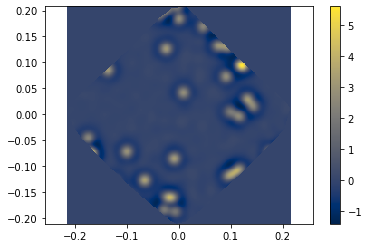

In [27]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.axis('equal')

(-0.2153622582198989,
 0.2157340670227011,
 -0.21083441749918405,
 0.20804460297945562)

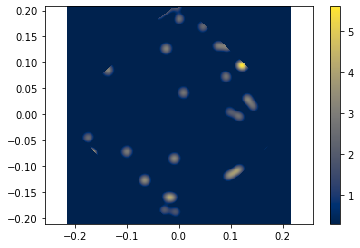

In [28]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.axis('equal')

In [31]:
S0 = -0.1
cwt_map_thresh = np.copy(cwt_map[:,:,0])
thresh_map = (cwt_map_thresh > S0)
cwt_map_thresh[~thresh_map] = 0

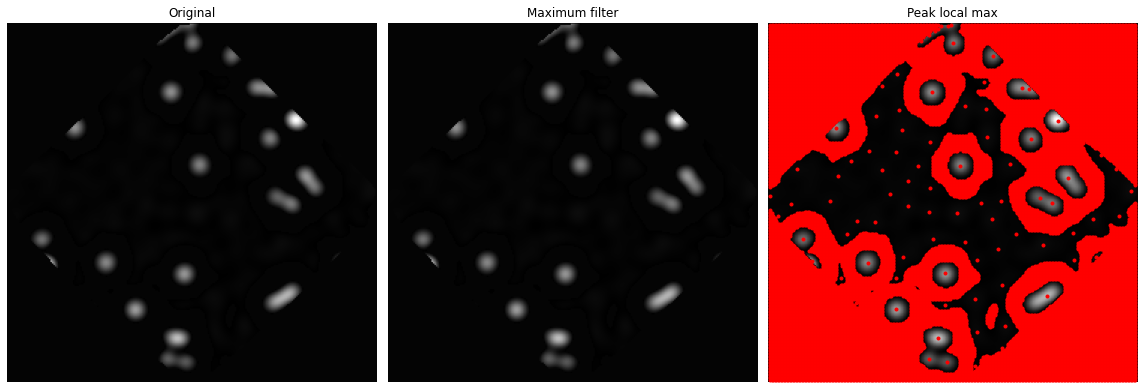

In [34]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# single a-value 
psf_degree = 0.4 
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = 1

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(cwt_map_thresh, size=N_pix_psf, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8*2, 6))
ax = axes.ravel()
ax[0].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')
ax[0].invert_yaxis()

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')
ax[1].invert_yaxis()

ax[2].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[2].plot(ps_approx[1], ps_approx[0], 'b.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
ax[2].invert_yaxis()

fig.tight_layout()

plt.show()

In [164]:
arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])

(-0.2153622582198989,
 0.2157340670227011,
 -0.21083441749918405,
 0.20804460297945562)

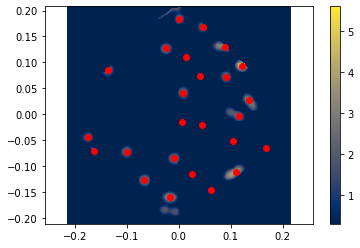

In [165]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.scatter(pos_x, pos_y, c = 'r')
plt.colorbar(plot)
ax.axis('equal')

In [166]:
arr_edge_points = projected_map['search_region_edge']
x_edge = arr_edge_points[:,0] ; y_edge = arr_edge_points[:,1]
x_in, y_in = maps.find_points_inside_curve_(pos_x, pos_y, x_edge, y_edge)

(-0.2153622582198989,
 0.2157340670227011,
 -0.21083441749918405,
 0.20804460297945562)

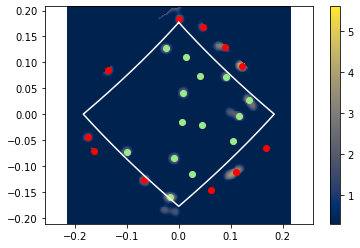

In [167]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.plot(x_edge, y_edge, c = 'white')
plt.scatter(pos_x, pos_y, c = 'r')
plt.scatter(x_in, y_in, c = 'lightgreen')
plt.colorbar(plot)
ax.axis('equal')

In [168]:
lon_c, lat_c = projected_map['center_coords']
r_ps = np.array([maps.inv_tangent_plane_proj_(x_in[n], y_in[n], lon_c, lat_c) for n in range(len(x_in))])

In [169]:
events_loc = np.load(map_dir + 'ps_loc.npy', allow_pickle = True)
l_events_loc = events_loc[:,0]
b_events_loc = events_loc[:,1]

phi_events_loc = l_events_loc.copy()
phi_events_loc[phi_events_loc>np.pi] = phi_events_loc[phi_events_loc>np.pi]-2*np.pi

lon_events_loc = phi_events_loc + np.pi
lat_events_loc = b_events_loc

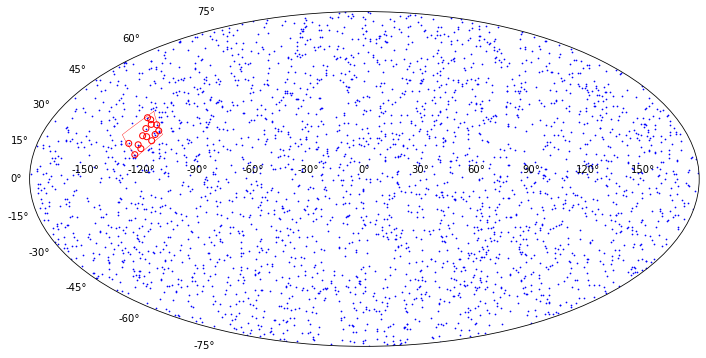

In [170]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)
lon_edge = arr_edge_points[npix, :, 0] ; lat_edge = arr_edge_points[npix, :, 1]

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_loc - np.pi, lat_events_loc, s = 0.5, c = 'blue')

In [171]:
events_ps = np.load(map_dir + 'ps_map.npy', allow_pickle = True)
l_events_ps = events_ps[:,0]
b_events_ps = events_ps[:,1]

phi_events_ps = l_events_ps.copy()
phi_events_ps[phi_events_ps>np.pi] = phi_events_ps[phi_events_ps>np.pi]-2*np.pi

lon_events_ps = phi_events_ps + np.pi
lat_events_ps = b_events_ps

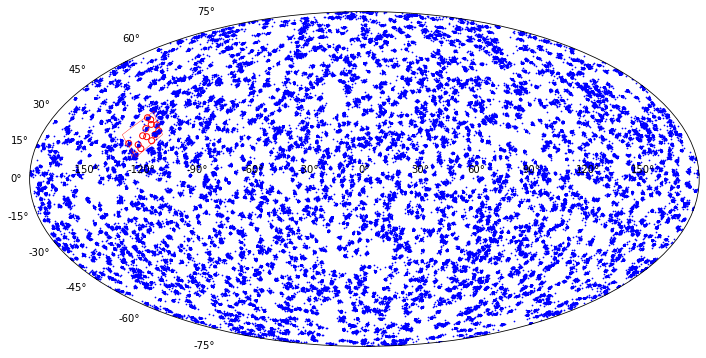

In [172]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.5, c = 'blue')

In [173]:
grouped_loc_lon, grouped_loc_lat = maps.divide_data_into_groups_(lon_events_loc, lat_events_loc, arr_edge_points)

In [174]:
lon_events_loc_npix = grouped_loc_lon[npix]
lat_events_loc_npix = grouped_loc_lat[npix]

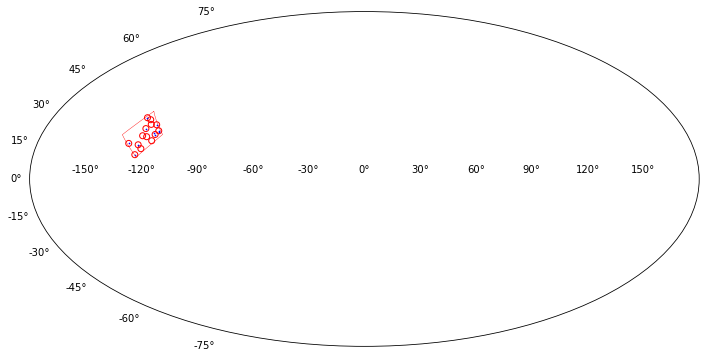

In [175]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_loc_npix - np.pi, lat_events_loc_npix, s = 0.5, c = 'blue')

In [176]:
r_loc = np.array(maps.tangent_plane_proj_(lat_events_loc_npix, lon_events_loc_npix, lat_c, lon_c))
x_loc = r_loc[:,0] ; y_loc = r_loc[:,1]

In [177]:
x_loc.shape

(10,)

(-0.2153622582198989,
 0.2157340670227011,
 -0.21083441749918405,
 0.20804460297945562)

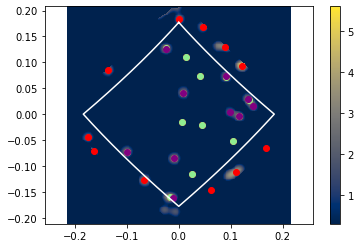

In [178]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.plot(x_edge, y_edge, c = 'white')
plt.scatter(pos_x, pos_y, c = 'r')
plt.scatter(x_in, y_in, c = 'lightgreen')
plt.scatter(x_loc, y_loc, c = 'purple')
plt.colorbar(plot)
ax.axis('equal')

In [179]:
# grid, mesh_bxby, arr_b, grid_flat, arr_bx_plot, arr_by_plot = maps.generate_grid_points_(x_edge, y_edge, grid_scale, True)

Ny,Nx = mesh_bxby.shape[:-1]
grid_pix_flat = maps.find_points_inside_curve_(arr_b[:,0], arr_b[:,1], x_edge, y_edge, return_grid=True) # 2D array
grid_pix = grid_pix_flat.reshape((Ny,Nx))

Text(0, 0.5, '$y$ (rad)')

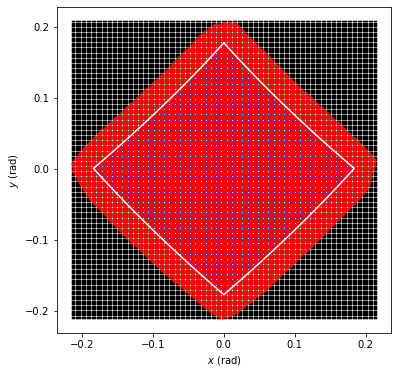

In [180]:
fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

# Ny,Nx = mesh_bxby.shape[:-1]
# binary_array = np.zeros((Ny,Nx))
# binary_array[grid] = 1
grid_flat = grid_dict['grid_flat']

# plt.pcolormesh(arr_bx_plot, arr_by_plot, binary_array, cmap=plt.cm.gray, shading='flat')

plt.scatter(arr_b[:,0], arr_b[:,1], s = 0.4, c = 'k')
plt.scatter(arr_b[grid_pix_flat,0], arr_b[grid_pix_flat,1], c = 'b', s = 0.4)
plt.scatter(arr_b[grid_flat,0], arr_b[grid_flat,1], c = 'r', s = 0.4)
ax.plot(x_edge,y_edge, c = 'w')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

In [181]:
def closest_grid_point_(point, grid_points):
    relative_positions = grid_points - point
    distances = np.linalg.norm(relative_positions, axis = -1)
    bxby_index_shape = distances.shape
    flattened_index = np.argmin(distances)
    return np.unravel_index(flattened_index, bxby_index_shape)

In [182]:
grid_points = arr_b[grid_pix_flat,:]
ind = closest_grid_point_([0,0], grid_points)
grid_points[ind]

array([ 0.0001859 , -0.00052224])

In [183]:
N_ps = r_loc.shape[0]
N_detect = len(x_in)
N_grid = grid_points.shape[0]

In [184]:
grid_points = arr_b[grid_pix_flat,:]

ps_approx = np.array([closest_grid_point_(r_loc[n], grid_points) for n in range(r_loc.shape[0])])
ps_approx_pos = grid_points[ps_approx]
detection_pos = np.stack((x_in, y_in), axis = -1)
relative_positions = ps_approx_pos - detection_pos
distances_from_ps = np.linalg.norm(relative_positions, axis = -1)

In [185]:
print(np.where(np.linalg.norm(grid_points[np.newaxis,:,:] - ps_approx_pos, axis = -1) == 0))
print(np.where(np.linalg.norm(grid_points[:,np.newaxis,:] - detection_pos, axis = -1) == 0))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([15485,  3983, 14402, 10711, 11740, 20588, 12953,    91, 18003,
        3167]))
(array([  110,  1502,  3167,  3983,  5816,  8701,  9442, 10918, 14229,
       15485, 18003, 18090, 20043, 20588]), array([ 0, 13,  2,  4, 10, 12,  8,  7,  1,  5,  6,  9, 11,  3]))


In [193]:
relative_positions = r_loc[:,np.newaxis,:] - detection_pos
distances_from_ps = np.linalg.norm(relative_positions, axis = -1)
min_rel_pos = np.min(distances_from_ps, axis = 0)

In [194]:
print(min_rel_pos.shape)

(14,)


In [208]:
thresh_dist = (min_rel_pos < np.sqrt(psf_scale**2 + grid_scale**2) )
min_rel_pos_thresh = min_rel_pos[thresh_dist] 

In [209]:
print(min_rel_pos)

[0.00556125 0.00287088 0.00075035 0.0003055  0.0007522  0.00060576
 0.00076776 0.00139225 0.05656527 0.04521812 0.04905848 0.04146387
 0.06000686 0.04556263]


In [210]:
min_rel_pos_thresh.shape

(8,)

In [211]:
tp = len(min_rel_pos_thresh) 
fp = len(min_rel_pos) - len(min_rel_pos_thresh)
fn = N_ps - tp
tn = N_grid - tp - fp - fn

print((tp + fp + tn + fn) / N_grid )

1.0


In [212]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

In [213]:
print(fpr)

0.0002808725774740193


In [126]:
print(ps_approx_pos.shape)
print(detection_pos.shape)
print(distances_from_ps.shape)

(10, 1, 2)
(8, 2)
(10, 8)


In [138]:
distances_from_ps.sort(axis = 0)

In [146]:
detection_pos = np.stack((x_in, y_in), axis = -1)
buf_r_loc = r_loc[:,np.newaxis,:]
buf_detection_pos = detection_pos[np.newaxis,:,:]
relative_pos = buf_r_loc - buf_detection_pos
print(relative_pos.shape)
distances_from_ps = np.linalg.norm(relative_positions, axis = -1)

#distances_from_ps.sort(axis = 0)
(np.min(distances_from_ps) < psf_scale + grid_scale).all(axis=0).any()
# check if detection coincides with a point source
# for n in range(detection_pos.shape[0]):
#     if (np.min(distances_from_ps) < psf_scale + grid_scale).all(axis=0).any():
    

(10, 8, 2)


True

In [134]:
A = np.array([[1,2,3], [0,3,1], [2,1,3]])

In [135]:
print(A)

[[1 2 3]
 [0 3 1]
 [2 1 3]]


In [136]:
A.sort(axis = 0)

In [137]:
print(A)

[[0 1 1]
 [1 2 3]
 [2 3 3]]
